# **NEURAL PROPHET**

## **Step 1: Data Preprocessing**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
data = pd.read_csv('tripv2pub 5.csv')

data = data[['PERSONID','TRIPID','TRAVDAY','TDAYDATE','STRTTIME','ENDTIME','TRPMILES','TRIPPURP','WHYFROM','WHYTO','TRPTRANS']]
data.sort_values(by='TDAYDATE')
data = data[(data['PERSONID'] == 1) & (data['WHYFROM'] == 1)]
print(data)

       PERSONID  TRIPID  TRAVDAY  TDAYDATE  STRTTIME  ENDTIME   TRPMILES  \
0             1       1        5    202201      1700     1710   0.635177   
2             1       1        1    202201      1100     1130   0.000000   
3             1       1        6    202201      1325     1340   1.535736   
5             1       1        2    202201      1300     1310   0.290864   
9             1       1        5    202201       730      751   8.264139   
...         ...     ...      ...       ...       ...      ...        ...   
31052         1       1        3    202301      2000     2020   2.096333   
31056         1       1        2    202301       515      530   7.865134   
31058         1       3        2    202301      1400     1430   8.802362   
31067         1       1        4    202301       715      745  14.883779   
31071         1       1        5    202301      1300     1315   1.250466   

       TRIPPURP  WHYFROM  WHYTO  TRPTRANS  
0             2        1     13         1  

**Converting STRTIME AND ENDTIME to timestamps**

In [4]:
data[['STRTTIME_OLD','ENDTIME_OLD']] = data[['STRTTIME','ENDTIME']]
print(data.head(4))

   PERSONID  TRIPID  TRAVDAY  TDAYDATE  STRTTIME  ENDTIME  TRPMILES  TRIPPURP  \
0         1       1        5    202201      1700     1710  0.635177         2   
2         1       1        1    202201      1100     1130  0.000000         3   
3         1       1        6    202201      1325     1340  1.535736         3   
5         1       1        2    202201      1300     1310  0.290864         2   

   WHYFROM  WHYTO  TRPTRANS  STRTTIME_OLD  ENDTIME_OLD  
0        1     13         1          1700         1710  
2        1     16        20          1100         1130  
3        1     17         1          1325         1340  
5        1     12        20          1300         1310  


In [5]:
# Ensure TRAVDAY and TRIPPURP are integers for processing
data['TRAVDAY'] = data['TRAVDAY'].astype(int)
data['TRIPPURP'] = data['TRIPPURP'].astype(int)

def convert_to_time_format(time_int):
    time_str = str(time_int).zfill(4)  # Convert to string and pad with zeros
    return time_str[:2] + ':' + time_str[2:]  # Insert colon between hours and minutes
# Convert TDAYDATE to datetime format representing YearMonth and then to YYYY-MM
data['TDAYDATE'] = pd.to_datetime(data['TDAYDATE'].astype(str), format='%Y%m').dt.strftime('%Y-%m')


# Apply the conversion function to STRTTIME and ENDTIME columns
data['STRTTIME'] = data['STRTTIME'].apply(convert_to_time_format)
data['ENDTIME'] = data['ENDTIME'].apply(convert_to_time_format)

print(data)


       PERSONID  TRIPID  TRAVDAY TDAYDATE STRTTIME ENDTIME   TRPMILES  \
0             1       1        5  2022-01    17:00   17:10   0.635177   
2             1       1        1  2022-01    11:00   11:30   0.000000   
3             1       1        6  2022-01    13:25   13:40   1.535736   
5             1       1        2  2022-01    13:00   13:10   0.290864   
9             1       1        5  2022-01    07:30   07:51   8.264139   
...         ...     ...      ...      ...      ...     ...        ...   
31052         1       1        3  2023-01    20:00   20:20   2.096333   
31056         1       1        2  2023-01    05:15   05:30   7.865134   
31058         1       3        2  2023-01    14:00   14:30   8.802362   
31067         1       1        4  2023-01    07:15   07:45  14.883779   
31071         1       1        5  2023-01    13:00   13:15   1.250466   

       TRIPPURP  WHYFROM  WHYTO  TRPTRANS  STRTTIME_OLD  ENDTIME_OLD  
0             2        1     13         1          1

In [6]:
# Strip leading and trailing spaces from the date and time columns
data['TDAYDATE'] = data['TDAYDATE'].str.strip()
data['STRTTIME'] = data['STRTTIME'].str.strip()
data['ENDTIME'] = data['ENDTIME'].str.strip()

# Combine date and time, convert to datetime, and format
data['STRTTIME'] = pd.to_datetime(data['TDAYDATE'] + ' ' + data['STRTTIME'], format='%Y-%m %H:%M', errors='coerce').dt.strftime('%H:%M')
data['ENDTIME'] = pd.to_datetime(data['TDAYDATE'] + ' ' + data['ENDTIME'], format='%Y-%m %H:%M', errors='coerce').dt.strftime('%H:%M')

# Check for and handle any NaT values if necessary
print(data.head(4))
print(data.dtypes)


   PERSONID  TRIPID  TRAVDAY TDAYDATE STRTTIME ENDTIME  TRPMILES  TRIPPURP  \
0         1       1        5  2022-01    17:00   17:10  0.635177         2   
2         1       1        1  2022-01    11:00   11:30  0.000000         3   
3         1       1        6  2022-01    13:25   13:40  1.535736         3   
5         1       1        2  2022-01    13:00   13:10  0.290864         2   

   WHYFROM  WHYTO  TRPTRANS  STRTTIME_OLD  ENDTIME_OLD  
0        1     13         1          1700         1710  
2        1     16        20          1100         1130  
3        1     17         1          1325         1340  
5        1     12        20          1300         1310  
PERSONID          int64
TRIPID            int64
TRAVDAY           int64
TDAYDATE         object
STRTTIME         object
ENDTIME          object
TRPMILES        float64
TRIPPURP          int64
WHYFROM           int64
WHYTO             int64
TRPTRANS          int64
STRTTIME_OLD      int64
ENDTIME_OLD       int64
dtype: objec

**Grouping the days based on Tripid**

**Attaching TDAYDATE with STRTTIME and ENDTIME along with d column**

In [7]:
from datetime import datetime, timedelta
def convert_to_full_date(row):
    # Parse the year and month
    first_day_of_month = datetime.strptime(row['TDAYDATE'], '%Y-%m')

    # Calculate the weekday (0=Monday, 1=Tuesday, ..., 6=Sunday)
    weekday = (row['TRAVDAY'] - 1) % 7  # Adjust TRAVDAY to Python's weekday (Monday=0, Sunday=6)

    # Find the first occurrence of the given weekday in the month
    first_weekday_of_month = first_day_of_month.weekday()  # 0=Monday, ..., 6=Sunday
    delta_days = (weekday - first_weekday_of_month + 7) % 7
    full_date = first_day_of_month + timedelta(days=delta_days)

    return full_date

# Apply the function to the DataFrame
data['FULLDATE'] = data.apply(convert_to_full_date, axis=1)

# Function to combine FULLDATE and STRTTIME
def combine_date_time(row):
    # Handle missing 'STRTTIME' values
    if pd.isna(row['STRTTIME']):
        return pd.NaT  # Return NaT for missing times

    # Combine date and time strings
    datetime_str = f"{row['FULLDATE'].strftime('%Y-%m-%d')} {row['STRTTIME']}"
    # Convert to datetime object
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')

# Apply the function to the DataFrame
data['FULL_DATETIME_STRT'] = data.apply(combine_date_time, axis=1)

# Print the DataFrame
print(data['FULL_DATETIME_STRT'].head())
print(data.dtypes)

0   2022-01-07 17:00:00
2   2022-01-03 11:00:00
3   2022-01-01 13:25:00
5   2022-01-04 13:00:00
9   2022-01-07 07:30:00
Name: FULL_DATETIME_STRT, dtype: datetime64[ns]
PERSONID                       int64
TRIPID                         int64
TRAVDAY                        int64
TDAYDATE                      object
STRTTIME                      object
ENDTIME                       object
TRPMILES                     float64
TRIPPURP                       int64
WHYFROM                        int64
WHYTO                          int64
TRPTRANS                       int64
STRTTIME_OLD                   int64
ENDTIME_OLD                    int64
FULLDATE              datetime64[ns]
FULL_DATETIME_STRT    datetime64[ns]
dtype: object


In [8]:
from datetime import datetime, timedelta
def convert_to_full_date(row):
    # Parse the year and month
    first_day_of_month = datetime.strptime(row['TDAYDATE'], '%Y-%m')

    # Calculate the weekday (0=Monday, 1=Tuesday, ..., 6=Sunday)
    weekday = (row['TRAVDAY'] - 1) % 7  # Adjust TRAVDAY to Python's weekday (Monday=0, Sunday=6)

    # Find the first occurrence of the given weekday in the month
    first_weekday_of_month = first_day_of_month.weekday()  # 0=Monday, ..., 6=Sunday
    delta_days = (weekday - first_weekday_of_month + 7) % 7
    full_date = first_day_of_month + timedelta(days=delta_days)

    return full_date

# Apply the function to the DataFrame
data['FULLDATE'] = data.apply(convert_to_full_date, axis=1)

# Function to combine FULLDATE and STRTTIME
def combine_date_time(row):
    # Handle missing 'STRTTIME' values
    if pd.isna(row['ENDTIME']):
        return pd.NaT  # Return NaT for missing times

    # Combine date and time strings
    datetime_str = f"{row['FULLDATE'].strftime('%Y-%m-%d')} {row['ENDTIME']}"
    # Convert to datetime object
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')

# Apply the function to the DataFrame
data['FULL_DATETIME_END'] = data.apply(combine_date_time, axis=1)

# Print the DataFrame
print(data['FULL_DATETIME_END'].head())
print(data.dtypes)

0   2022-01-07 17:10:00
2   2022-01-03 11:30:00
3   2022-01-01 13:40:00
5   2022-01-04 13:10:00
9   2022-01-07 07:51:00
Name: FULL_DATETIME_END, dtype: datetime64[ns]
PERSONID                       int64
TRIPID                         int64
TRAVDAY                        int64
TDAYDATE                      object
STRTTIME                      object
ENDTIME                       object
TRPMILES                     float64
TRIPPURP                       int64
WHYFROM                        int64
WHYTO                          int64
TRPTRANS                       int64
STRTTIME_OLD                   int64
ENDTIME_OLD                    int64
FULLDATE              datetime64[ns]
FULL_DATETIME_STRT    datetime64[ns]
FULL_DATETIME_END     datetime64[ns]
dtype: object


## **Neural Prophet**

In [9]:
!pip install neuralprophet

zsh:1: command not found: pip


## **Step 2: Building Neural Prophet**

In [10]:
from neuralprophet import NeuralProphet

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
print(data.columns)

Index(['PERSONID', 'TRIPID', 'TRAVDAY', 'TDAYDATE', 'STRTTIME', 'ENDTIME',
       'TRPMILES', 'TRIPPURP', 'WHYFROM', 'WHYTO', 'TRPTRANS', 'STRTTIME_OLD',
       'ENDTIME_OLD', 'FULLDATE', 'FULL_DATETIME_STRT', 'FULL_DATETIME_END'],
      dtype='object')


## **Start Time Prediction**

In [12]:
import pandas as pd
from neuralprophet import NeuralProphet



# Aggregate TRPMILES by averaging for duplicate FULL_DATETIME_STRT timestamps
data_aggregated = data.groupby('FULL_DATETIME_STRT').agg({

    'STRTTIME_OLD':'first' # Or any other aggregation that makes sense for your data
}).reset_index()


def prepare_data(df, datetime_column, value_column):
    # Create a dataframe with 'ds' and 'y' columns
    df_prepared = df[[datetime_column, value_column]].copy()
    df_prepared.rename(columns={datetime_column: 'ds', value_column: 'y'}, inplace=True)
    return df_prepared

def train_neuralprophet(df_prepared, epochs=100, future_periods=1):
    model = NeuralProphet(epochs=epochs)
    model.fit(df_prepared, freq='h')
    #future = model.make_future_dataframe(df_prepared, periods=future_periods)
    forecast = model.predict(df_prepared)
    return model, forecast

df_strttime = prepare_data(data_aggregated, 'FULL_DATETIME_STRT', 'STRTTIME_OLD')
model_strttime, forecast_strttime = train_neuralprophet(df_strttime)



WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 22.446% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_au

Epoch 100: 100%|██████████| 100/100 [00:00<00:00, 1278.72it/s, loss=0.000315, v_num=0, MAE=12.40, RMSE=18.10, Loss=0.000167, RegLoss=0.000]  

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 22.446% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an altern


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 505.96it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralproph

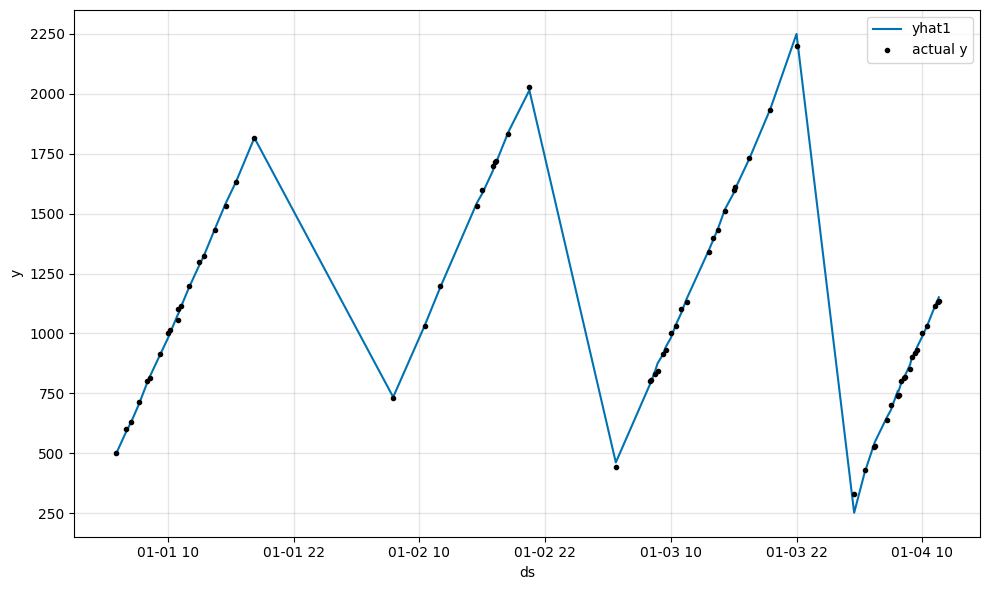

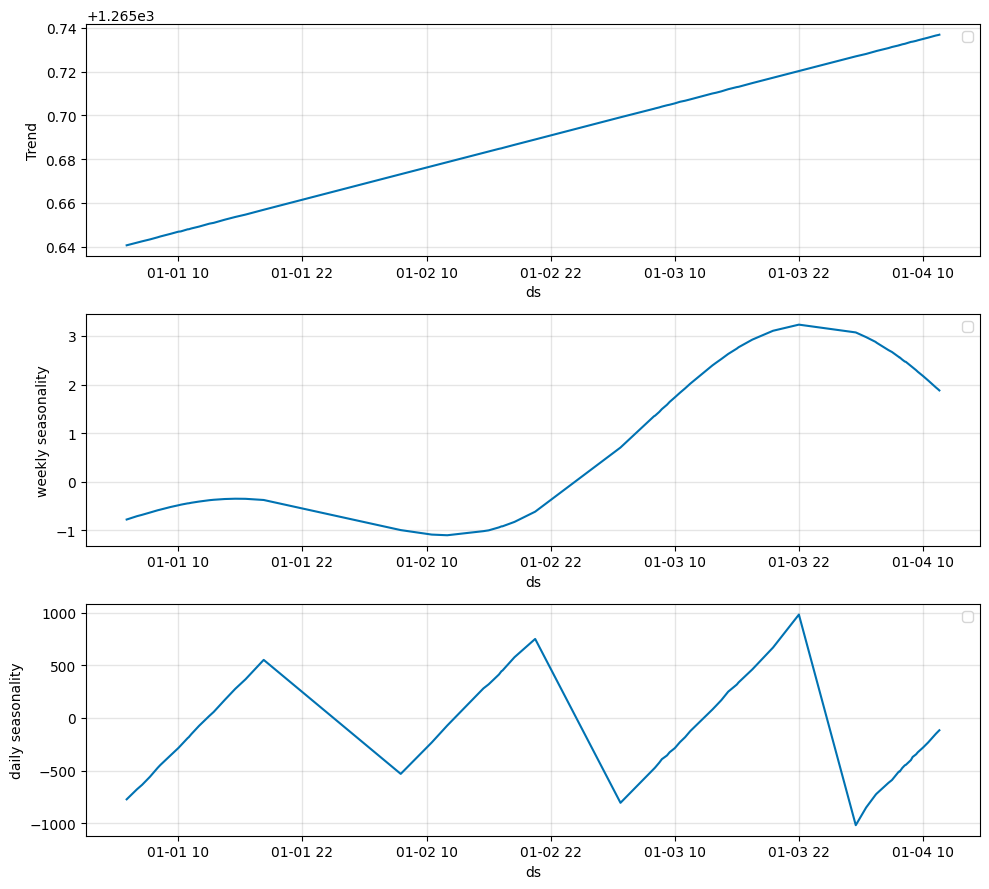

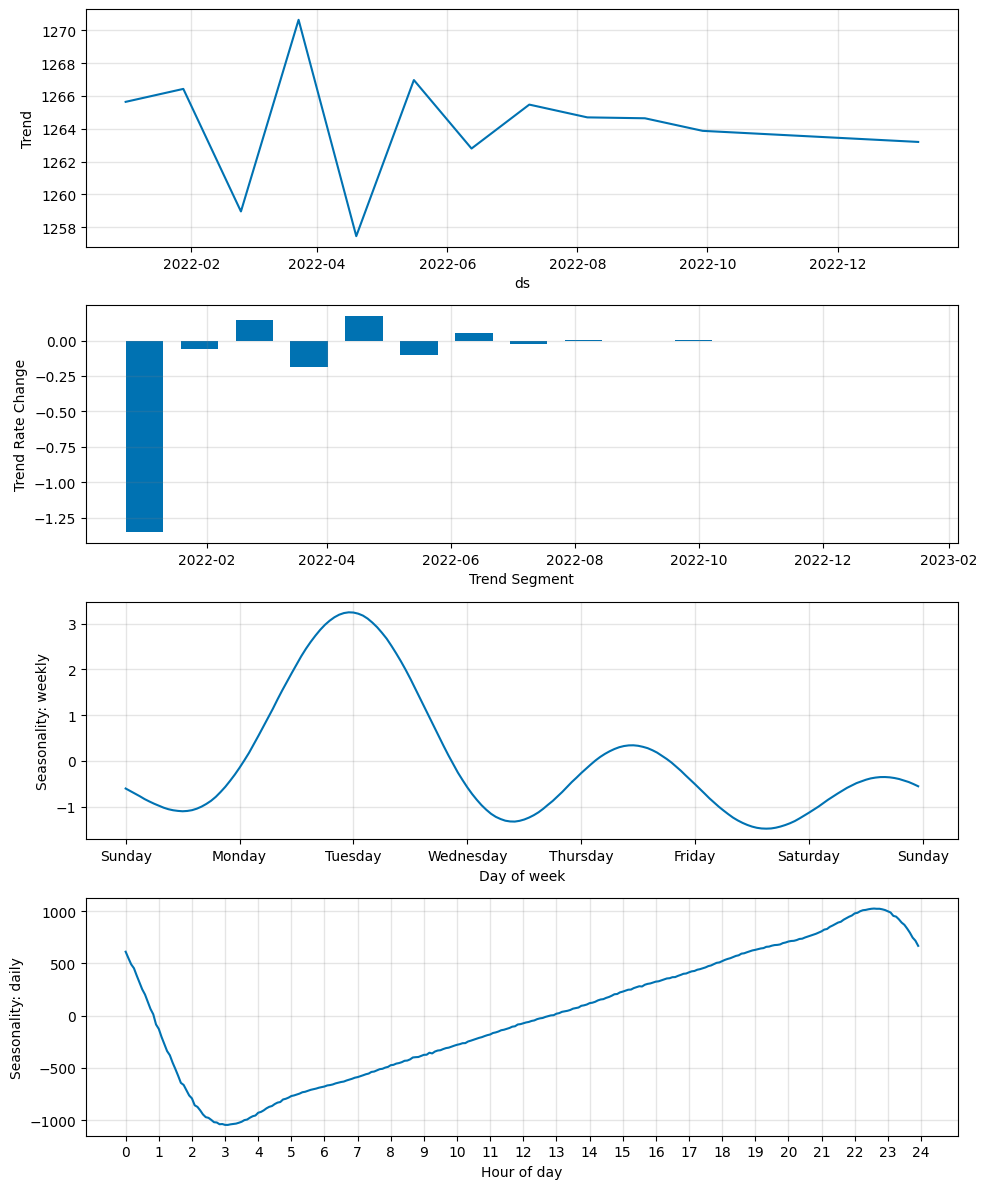

In [13]:
forecast_strttime_plt = forecast_strttime.head(70)
fig_forecast_strttime = model_strttime.plot(forecast_strttime_plt , plotting_backend='matplotlib')
fig_components_strttime = model_strttime.plot_components(forecast_strttime_plt , plotting_backend='matplotlib')
fig_model_strttime = model_strttime.plot_parameters(plotting_backend='matplotlib')
plt.show()

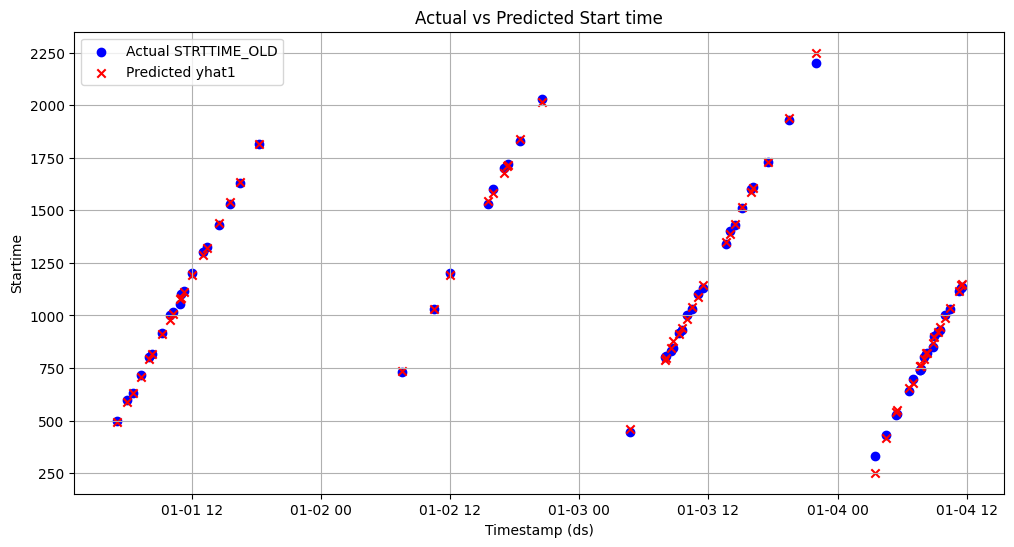

In [14]:
import matplotlib.pyplot as plt

# Extract the relevant portions of the forecast dataframe
forecast_strttime_subset = forecast_strttime.head(70)

# Extract actual values corresponding to the same timestamps
actual_strttime_subset = data_aggregated.set_index('FULL_DATETIME_STRT').reindex(forecast_strttime_subset['ds']).reset_index()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(actual_strttime_subset['ds'], actual_strttime_subset['STRTTIME_OLD'], label='Actual STRTTIME_OLD', color='blue', marker='o')
plt.scatter(forecast_strttime_subset['ds'], forecast_strttime_subset['yhat1'], label='Predicted yhat1', color='red', marker='x')
plt.xlabel('Timestamp (ds)')
plt.ylabel('Startime')
plt.title('Actual vs Predicted Start time')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
metrics_strttime = model_strttime.test(df_strttime)
print('Start Time Model Metrics:', metrics_strttime)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 22.446% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 335.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │  0.00015477972920052707   │
│          MAE_val          │    12.252889633178711     │
│         RMSE_val          │     20.4079532623291      │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Start Time Model Metrics:     MAE_val   RMSE_val  Loss_test  RegLoss_test
0  12.25289  20.407953   0.000155           0.0


In [16]:
# Forecast Start Time for the next day
future_strttime = model_strttime.make_future_dataframe(df_strttime, periods=10)
forecast_strttime = model_strttime.predict(future_strttime)
# forecast_endtime['yhat1'] = pd.to_datetime(forecast_endtime['yhat1'], unit='s')
print('Next day Start Time forecast:', forecast_strttime[['yhat1']])


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 22.446% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 572.37it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



Next day Start Time forecast:          yhat1
0  2040.545288
1  2193.324707
2  2288.082275
3  2000.974243
4  1315.027222
5   595.452881
6   235.558685
7   283.704193
8   458.421509
9   569.749268


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fcst = fcst.fillna(value=np.nan)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objec

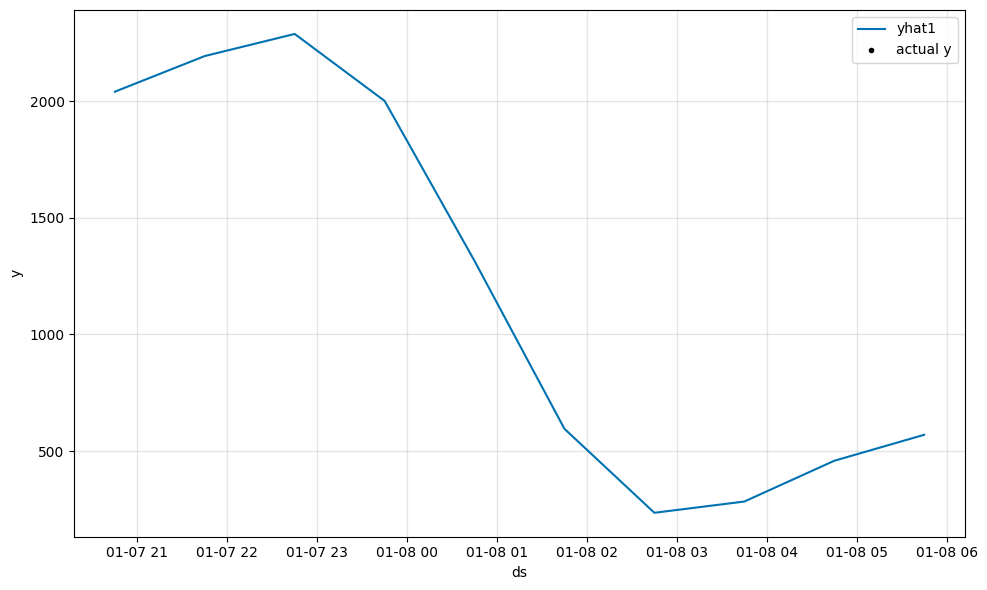

In [17]:

fig_forecast_strttime = model_strttime.plot(forecast_strttime, plotting_backend='matplotlib')
plt.show()

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fcst = fcst.fillna(value=np.nan)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objec

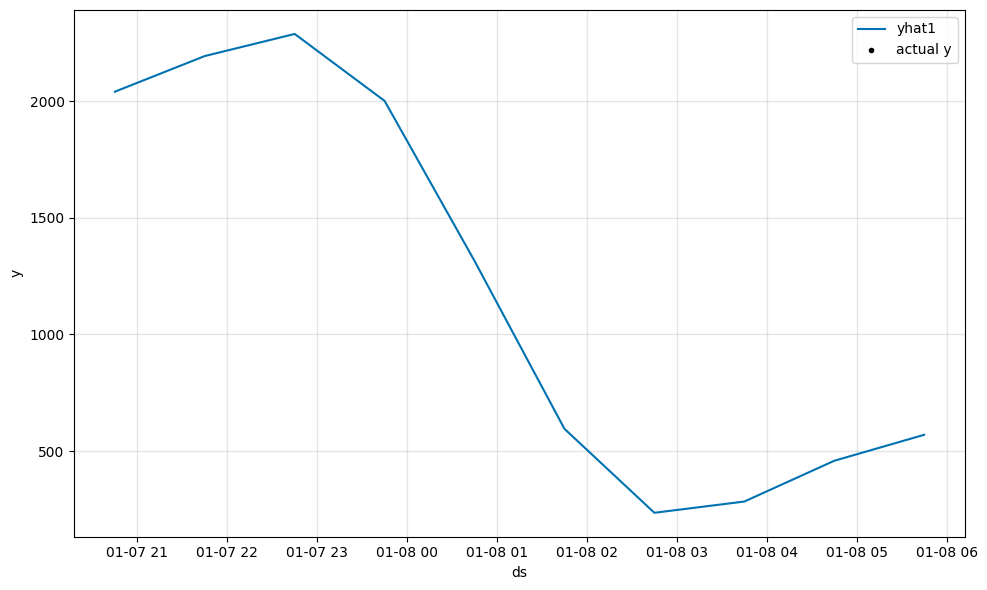

In [18]:
forecast_strttime_plt3 = forecast_strttime.tail(100)
fig_forecast_strttime = model_strttime.plot(forecast_strttime_plt3, plotting_backend='matplotlib')
plt.show()

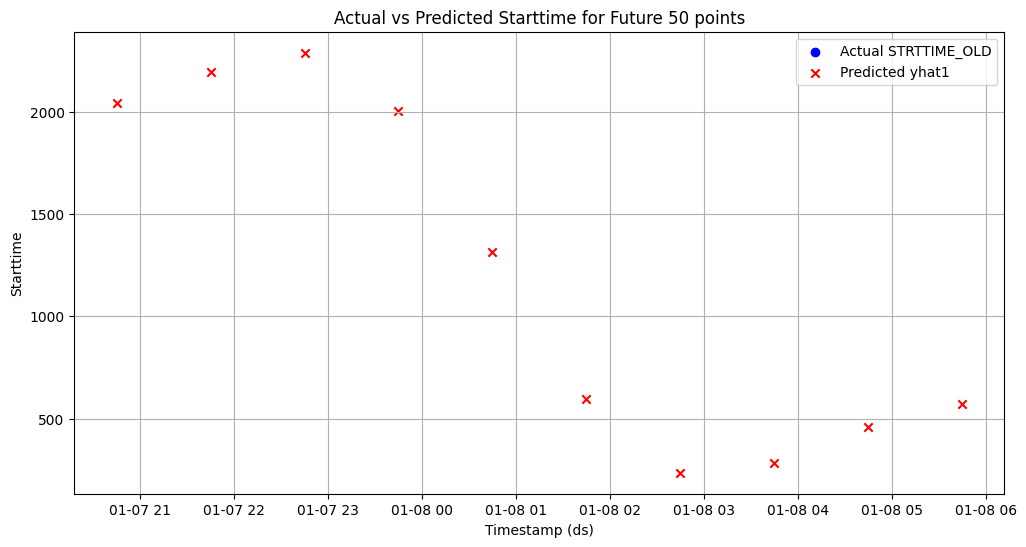

In [19]:
import matplotlib.pyplot as plt

# Extract the relevant portions of the forecast dataframe
forecast_strttime_subset = forecast_strttime.tail(70)

# Extract actual values corresponding to the same timestamps
actual_strttime_subset = data_aggregated.set_index('FULL_DATETIME_STRT').reindex(forecast_strttime_subset['ds']).reset_index()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(actual_strttime_subset['ds'], actual_strttime_subset['STRTTIME_OLD'], label='Actual STRTTIME_OLD', color='blue', marker='o')
plt.scatter(forecast_strttime_subset['ds'], forecast_strttime_subset['yhat1'], label='Predicted yhat1', color='red', marker='x')
plt.xlabel('Timestamp (ds)')
plt.ylabel('Starttime')
plt.title('Actual vs Predicted Starttime for Future 50 points')
plt.legend()
plt.grid(True)
plt.show()


## **END TIME PREDICTION**

In [20]:
import pandas as pd
from neuralprophet import NeuralProphet



# Aggregate TRPMILES by averaging for duplicate FULL_DATETIME_STRT timestamps
data_aggregated = data.groupby('FULL_DATETIME_END').agg({

    'ENDTIME_OLD':'first' # Or any other aggregation that makes sense for your data
}).reset_index()

# Convert FULL_DATETIME_END to a timestamp for modeling
#data_aggregated['FULL_DATETIME_END_timestamp'] = data_aggregated['FULL_DATETIME_END'].astype(int) / 10**9

def prepare_data(df, datetime_column, value_column):
    # Create a dataframe with 'ds' and 'y' columns
    df_prepared = df[[datetime_column, value_column]].copy()
    df_prepared.rename(columns={datetime_column: 'ds', value_column: 'y'}, inplace=True)
    return df_prepared

def train_neuralprophet(df_prepared, epochs=150, future_periods=1):
    model = NeuralProphet(epochs=epochs)
    model.fit(df_prepared, freq='h')
    #future = model.make_future_dataframe(df_prepared, periods=future_periods)
    forecast = model.predict(df_prepared)
    return model, forecast

df_endtime = prepare_data(data_aggregated, 'FULL_DATETIME_END', 'ENDTIME_OLD')
model_endtime, forecast_endtime = train_neuralprophet(df_endtime)



WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 24.342% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_aut

Epoch 150: 100%|██████████| 150/150 [00:00<00:00, 1552.58it/s, loss=0.000751, v_num=1, MAE=13.20, RMSE=23.70, Loss=0.000394, RegLoss=0.000]  


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 24.342% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alterna

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 543.53it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [21]:
forecast_endtime = forecast_endtime.head(100)
# fig_forecast_endtime = model_endtime.plot(forecast_endtime, plotting_backend='matplotlib')
# fig_components_endtime = model_endtime.plot_components(forecast_endtime, plotting_backend='matplotlib')
# fig_model_endtime = model_endtime.plot_parameters(plotting_backend='matplotlib')
plt.show()

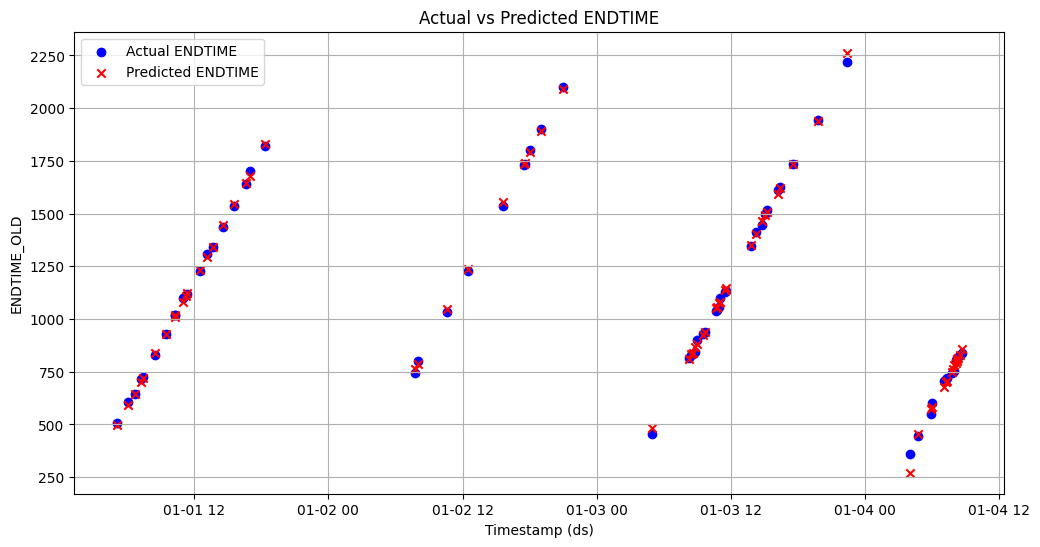

In [22]:
import matplotlib.pyplot as plt

# Extract the relevant portions of the forecast dataframe
forecast_endtime_subset = forecast_endtime.head(70)

# Extract actual values corresponding to the same timestamps
actual_endtime_subset = data_aggregated.set_index('FULL_DATETIME_END').reindex(forecast_endtime_subset['ds']).reset_index()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(actual_endtime_subset['ds'], actual_endtime_subset['ENDTIME_OLD'], label='Actual ENDTIME', color='blue', marker='o')
plt.scatter(forecast_endtime_subset['ds'], forecast_endtime_subset['yhat1'], label='Predicted ENDTIME', color='red', marker='x')
plt.xlabel('Timestamp (ds)')
plt.ylabel('ENDTIME_OLD')
plt.title('Actual vs Predicted ENDTIME')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
metrics_endtime = model_endtime.test(df_endtime)
print('End Time Model Metrics:', metrics_endtime)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 24.342% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 355.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │  0.00037533207796514034   │
│          MAE_val          │    13.261384010314941     │
│         RMSE_val          │     34.43718719482422     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

End Time Model Metrics:      MAE_val   RMSE_val  Loss_test  RegLoss_test
0  13.261384  34.437187   0.000375           0.0


In [24]:
# Forecast FULL_DATETIME_END for the next day
future_endtime = model_endtime.make_future_dataframe(df_endtime, periods=50,n_historic_predictions=len(df_endtime))
forecast_endtime = model_endtime.predict(future_endtime)
# forecast_endtime['yhat1'] = pd.to_datetime(forecast_endtime['yhat1'], unit='s')
print('Next day END forecast:', forecast_endtime[['yhat1']])



# Find out the range of predicted values
print('Predicted from:', forecast_endtime['ds'].min())
print('Predicted until:', forecast_endtime['ds'].max())


WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5min corresponds to 24.342% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view 

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 529.27it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



Next day END forecast:             yhat1
0      499.382538
1      591.799805
2      646.506958
3      700.479736
4      719.825134
...           ...
5402  1574.145752
5403  1673.684082
5404  1788.593750
5405  1888.395630
5406  1963.216675

[5407 rows x 1 columns]
Predicted from: 2022-01-01 05:05:00
Predicted until: 2023-01-09 20:00:00


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fcst = fcst.fillna(value=np.nan)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objec

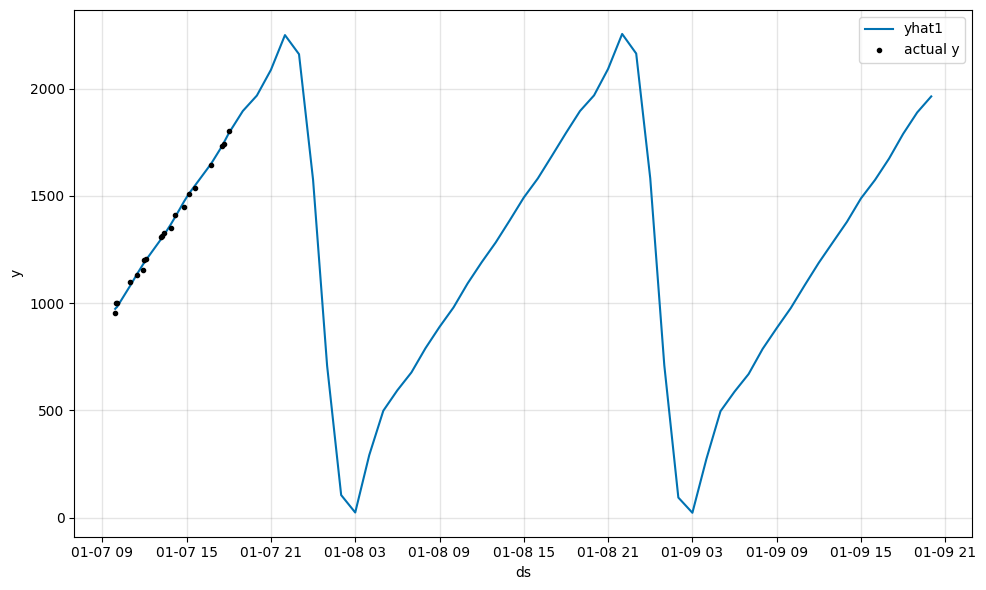

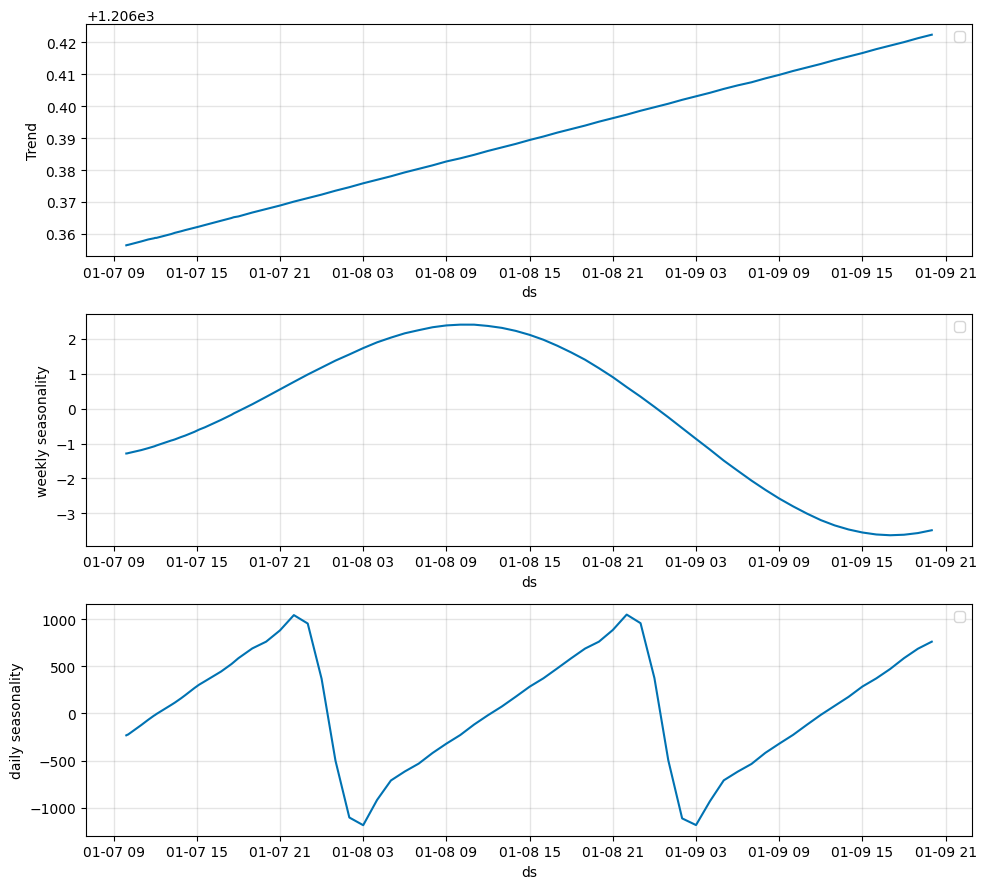

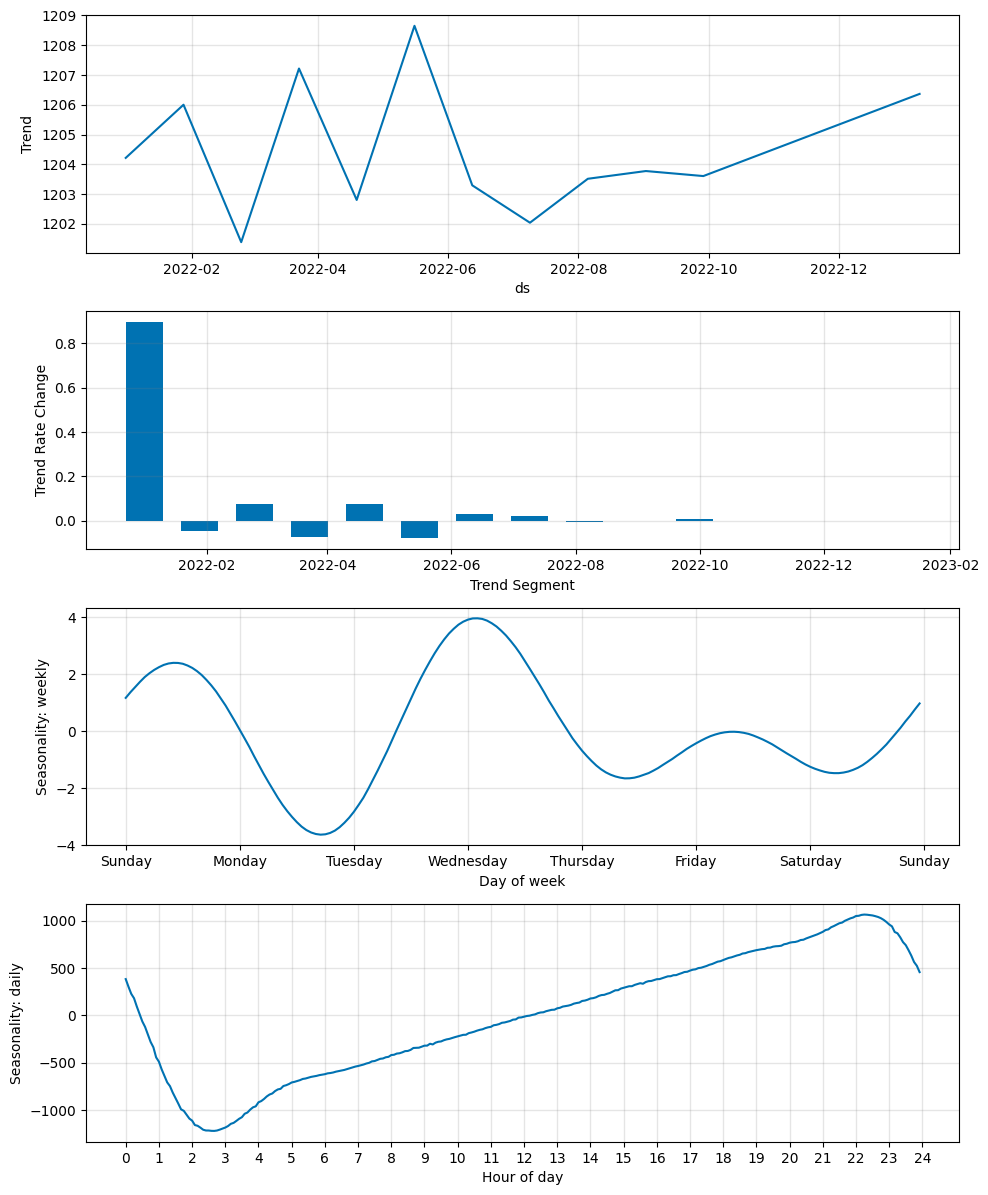

In [25]:
forecast_endtime = forecast_endtime.tail(70)
fig_forecast_endtime = model_endtime.plot(forecast_endtime, plotting_backend='matplotlib')
fig_components_endtime = model_endtime.plot_components(forecast_endtime, plotting_backend='matplotlib')
fig_model_endtime = model_endtime.plot_parameters(plotting_backend='matplotlib')
plt.show()

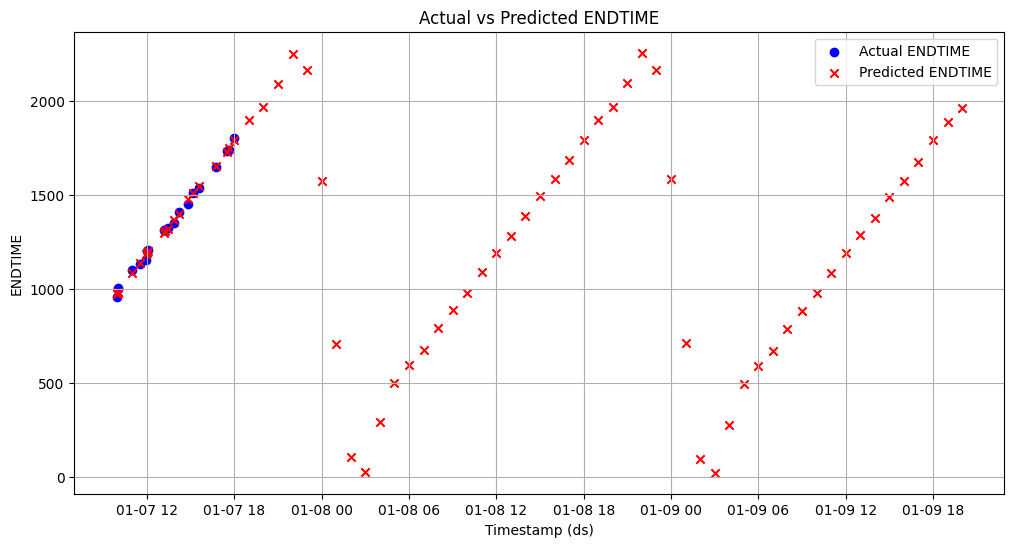

In [26]:
import matplotlib.pyplot as plt

# Extract the relevant portions of the forecast dataframe
forecast_endtime_subset = forecast_endtime.head(70)

# Extract actual values corresponding to the same timestamps
actual_endtime_subset = data_aggregated.set_index('FULL_DATETIME_END').reindex(forecast_endtime_subset['ds']).reset_index()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(actual_endtime_subset['ds'], actual_endtime_subset['ENDTIME_OLD'], label='Actual ENDTIME', color='blue', marker='o')
plt.scatter(forecast_endtime_subset['ds'], forecast_endtime_subset['yhat1'], label='Predicted ENDTIME', color='red', marker='x')
plt.xlabel('Timestamp (ds)')
plt.ylabel('ENDTIME')
plt.title('Actual vs Predicted ENDTIME')
plt.legend()
plt.grid(True)
plt.show()


## **PREDICTED TRIP MILES**

In [27]:
import pandas as pd
from neuralprophet import NeuralProphet



# Aggregate TRPMILES by averaging for duplicate FULL_DATETIME_STRT timestamps
data_aggregated = data.groupby('FULL_DATETIME_STRT').agg({
    'TRPMILES': 'first' # Or any other aggregation that makes sense for your data
}).reset_index()


def prepare_data(df, datetime_column, value_column):
    # Create a dataframe with 'ds' and 'y' columns
    df_prepared = df[[datetime_column, value_column]].copy()
    df_prepared.rename(columns={datetime_column: 'ds', value_column: 'y'}, inplace=True)
    return df_prepared

def train_neuralprophet(df_prepared, epochs=100, future_periods=1):
    model = NeuralProphet(epochs=epochs)
    model.fit(df_prepared, freq='h')
    future = model.make_future_dataframe(df_prepared, periods=future_periods)
    forecast = model.predict(df_prepared)
    return model, forecast

# Prepare data for TRPMILES prediction
df_trpmiles = prepare_data(data_aggregated, 'FULL_DATETIME_STRT', 'TRPMILES')
model_trpmiles, forecast_trpmiles = train_neuralprophet(df_trpmiles)




WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 22.446% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_au

Epoch 100: 100%|██████████| 100/100 [00:00<00:00, 1276.83it/s, loss=0.0803, v_num=2, MAE=7.120, RMSE=14.40, Loss=0.0709, RegLoss=0.000]  

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 22.446% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view


Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 586.58it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



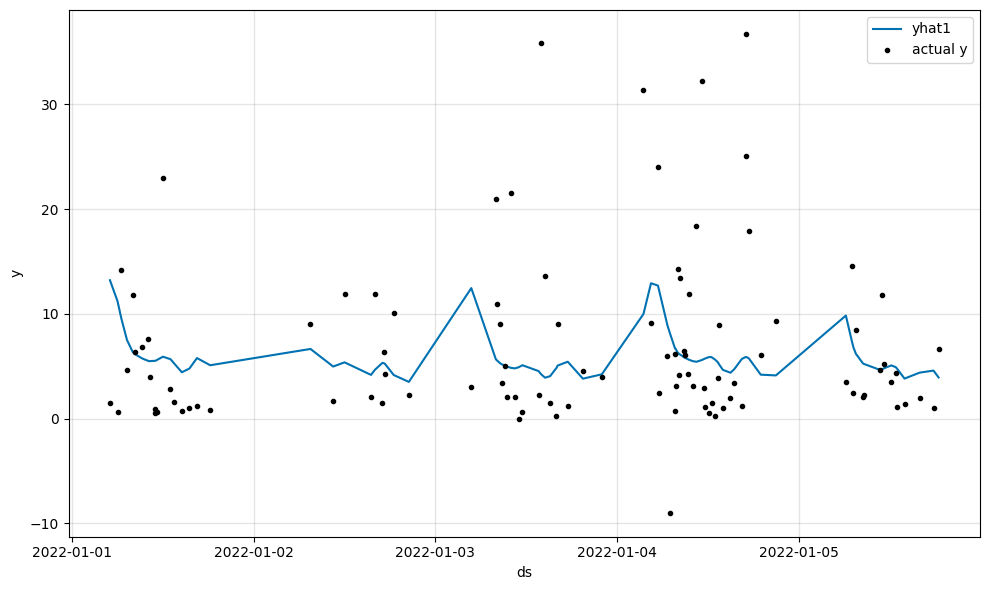

In [28]:
forecast_trpmiles = forecast_trpmiles.head(100)

fig_forecast_trpmiles = model_trpmiles.plot(forecast_trpmiles, plotting_backend='matplotlib')
plt.show()

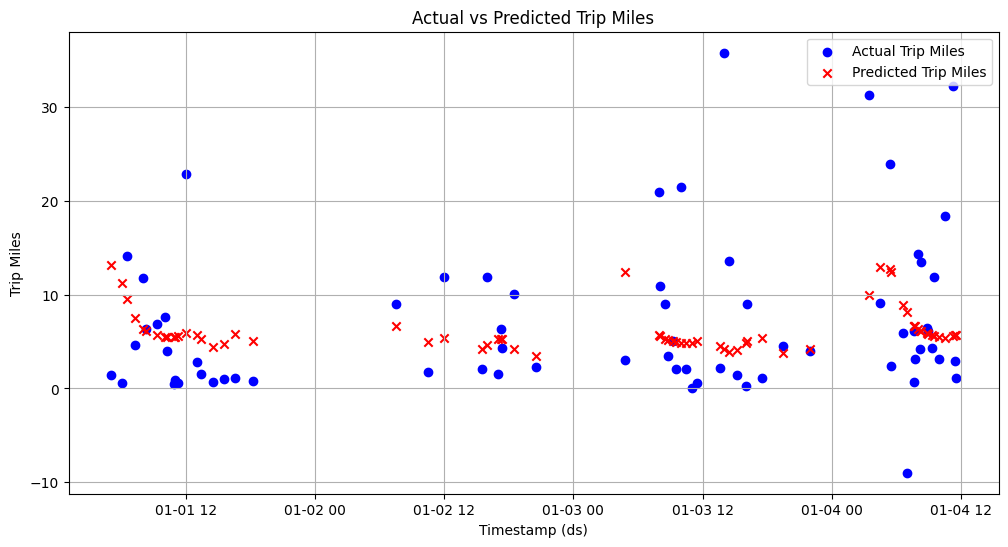

In [29]:
import matplotlib.pyplot as plt

# Extract the relevant portions of the forecast dataframe
forecast_trpmiles_subset = forecast_trpmiles.head(70)

# Extract actual values corresponding to the same timestamps
# Use 'FULL_DATETIME_STRT' as index for alignment, assuming it's unique
actual_trpmiles_subset = data_aggregated.set_index('FULL_DATETIME_STRT').reindex(forecast_trpmiles_subset['ds']).reset_index()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(actual_trpmiles_subset['ds'], actual_trpmiles_subset['TRPMILES'], label='Actual Trip Miles', color='blue', marker='o')
plt.scatter(forecast_trpmiles_subset['ds'], forecast_trpmiles_subset['yhat1'], label='Predicted Trip Miles', color='red', marker='x')
plt.xlabel('Timestamp (ds)')
plt.ylabel('Trip Miles')
plt.title('Actual vs Predicted Trip Miles')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
metrics_trpmiles = model_trpmiles.test(df_trpmiles)
print('TRPMILES Model Metrics:', metrics_trpmiles)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15min corresponds to 22.446% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq h. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 372.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.07087571918964386    │
│          MAE_val          │    6.9490509033203125     │
│         RMSE_val          │    15.810742378234863     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

TRPMILES Model Metrics:     MAE_val   RMSE_val  Loss_test  RegLoss_test
0  6.949051  15.810742   0.070876           0.0


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralprophet/plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/neuralproph

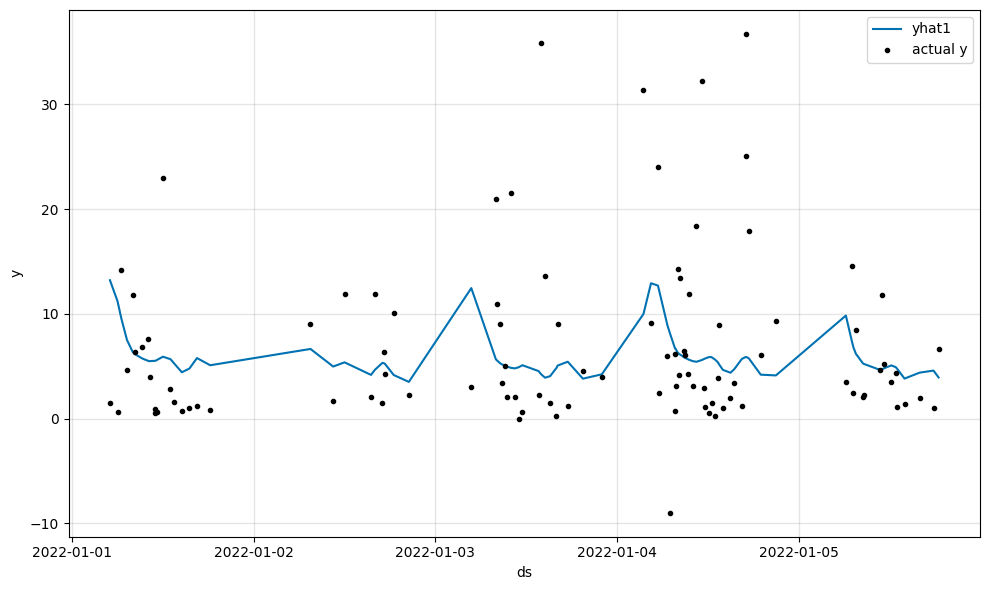

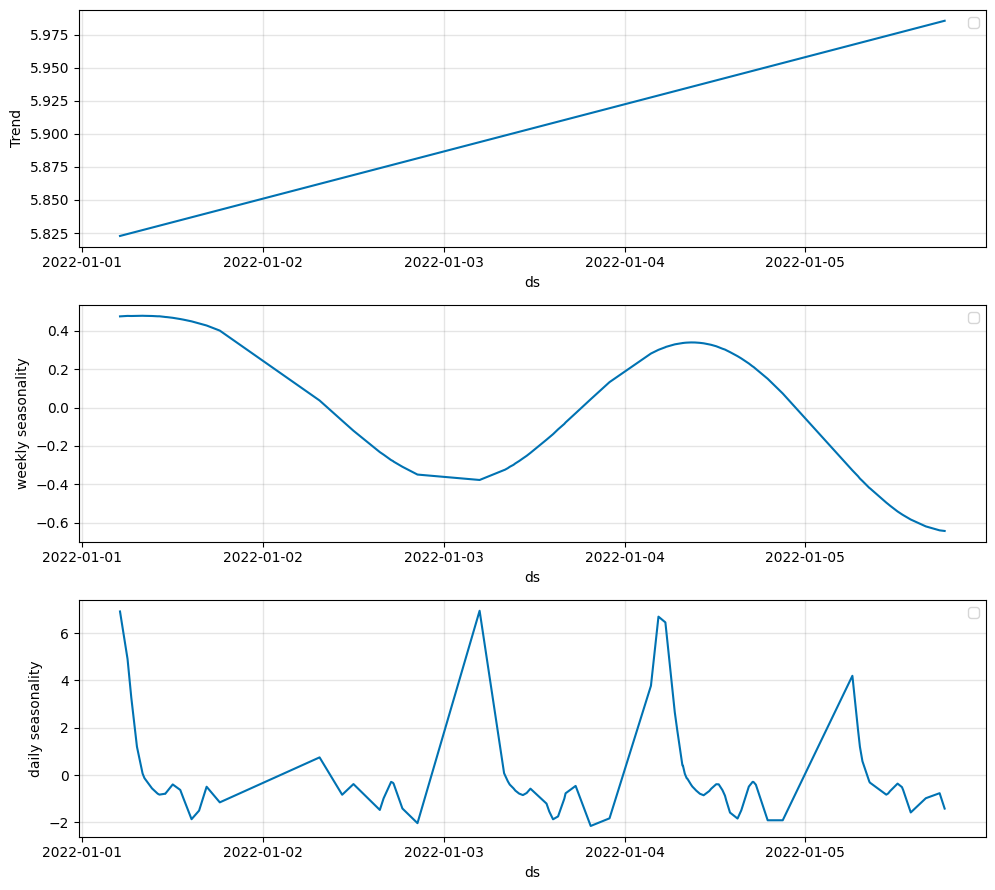

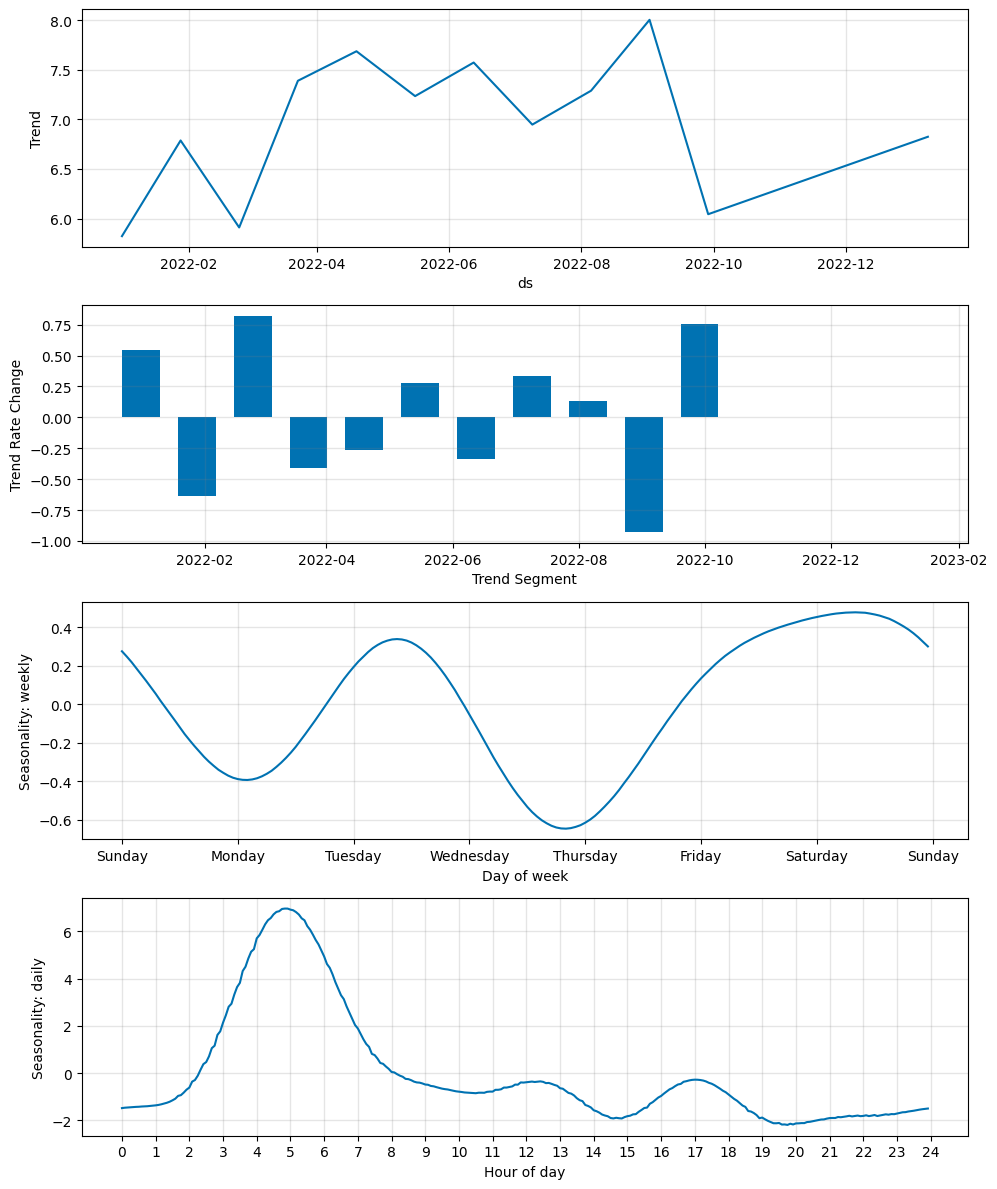

In [31]:
fig_forecast_trpmiles = model_trpmiles.plot(forecast_trpmiles, plotting_backend='matplotlib')
fig_components_trpmiles = model_trpmiles.plot_components(forecast_trpmiles, plotting_backend='matplotlib')
fig_model_trpmiles = model_trpmiles.plot_parameters(plotting_backend='matplotlib')
plt.show()

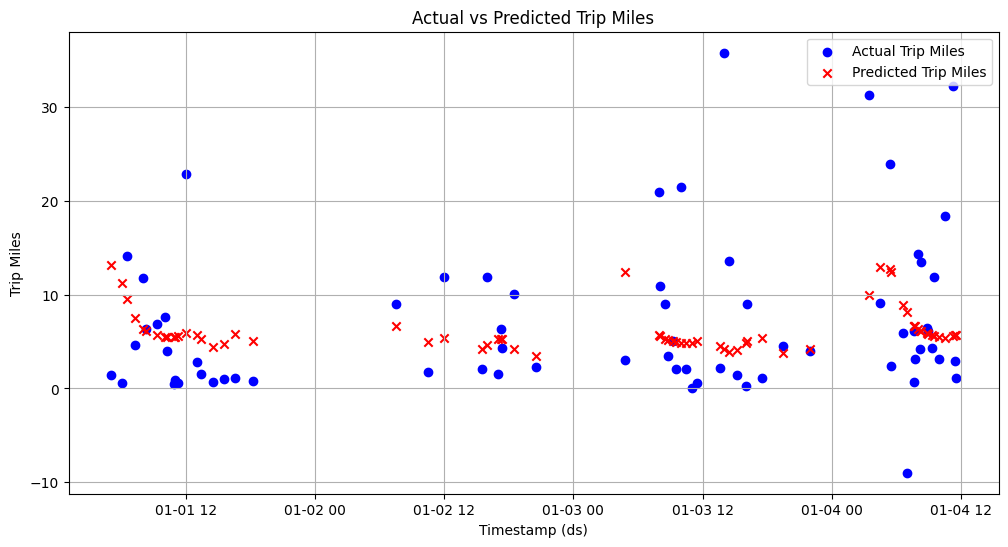

In [32]:
import matplotlib.pyplot as plt

# Extract the relevant portions of the forecast dataframe
forecast_trpmiles_subset = forecast_trpmiles.head(70)

# Extract actual values corresponding to the same timestamps
# Use 'FULL_DATETIME_STRT' as index for alignment, assuming it's unique
actual_trpmiles_subset = data_aggregated.set_index('FULL_DATETIME_STRT').reindex(forecast_trpmiles_subset['ds']).reset_index()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(actual_trpmiles_subset['ds'], actual_trpmiles_subset['TRPMILES'], label='Actual Trip Miles', color='blue', marker='o')
plt.scatter(forecast_trpmiles_subset['ds'], forecast_trpmiles_subset['yhat1'], label='Predicted Trip Miles', color='red', marker='x')
plt.xlabel('Timestamp (ds)')
plt.ylabel('Trip Miles')
plt.title('Actual vs Predicted Trip Miles')
plt.legend()
plt.grid(True)
plt.show()

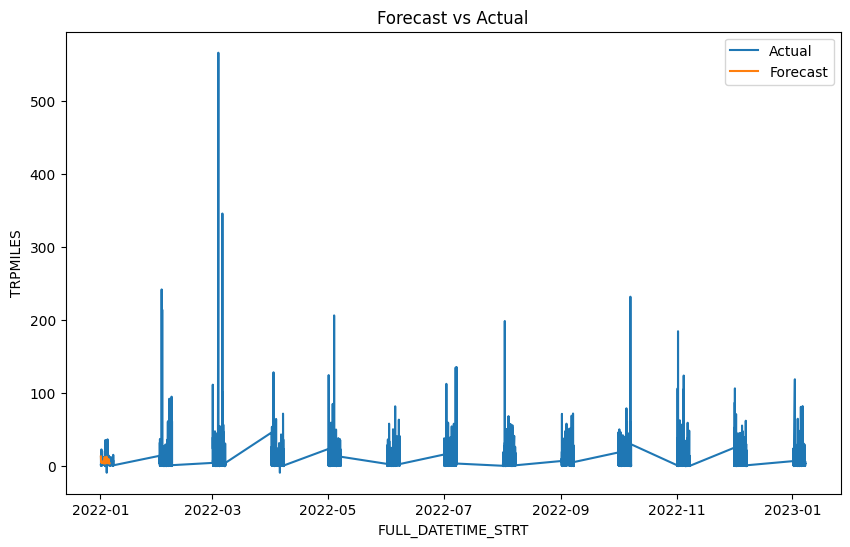

In [33]:
def plot_forecast(model, forecast, df_original, datetime_column, value_column):
    # Plot the original data and the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(df_original[datetime_column], df_original[value_column], label='Actual')
    plt.plot(forecast['ds'], forecast['yhat1'], label='Forecast')
    #plt.fill_between(forecast['ds'], forecast['yhat1 lower'], forecast['yhat1 upper'], alpha=0.2, label='Confidence Interval')
    plt.xlabel(datetime_column)
    plt.ylabel(value_column)
    plt.title('Forecast vs Actual')
    plt.legend()
    plt.show()
plot_forecast(model_trpmiles, forecast_trpmiles, data_aggregated, 'FULL_DATETIME_STRT', 'TRPMILES')

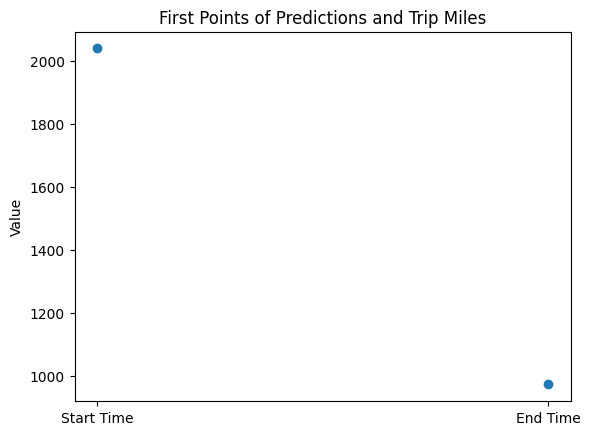

In [34]:
# Extract the first point from forecast_strttime and forecast_endtime
first_predicted_starttime = forecast_strttime['yhat1'].iloc[0]
first_predicted_endtime = forecast_endtime['yhat1'].iloc[0]

# Extract the first TRPMILES value (assuming 'data' is your original DataFrame)


# Now you have the three values you want to plot.
# You can use matplotlib to create a simple scatter plot.
import matplotlib.pyplot as plt
plt.scatter(['Start Time', 'End Time'], [first_predicted_starttime, first_predicted_endtime])
plt.ylabel('Value')
plt.title('First Points of Predictions and Trip Miles')
plt.show()

In [ ]:
print("Ran till here")

## **SQL** **DATABASE**

In [37]:
# Assuming forecast_strttime and forecast_endtime are DataFrames
# Ensure they have a 'yhat1' column and other relevant columns for the CSV

# Combine both DataFrames into one
combined_predictions = pd.DataFrame({
    'forecast_strttime': forecast_strttime['yhat1'],
    'forecast_endtime': forecast_endtime['yhat1']
})

# Save to CSV
combined_predictions.to_csv('predictions.csv', index=False)
